In [1]:
import pymc as pm 
import pandas as pd
import numpy as np
import seaborn as sns
# import theano.tensor as tt
# import aesara.tensor as at
from matplotlib import pyplot as plt

In [2]:
pm.__version__

'5.1.2'

In [3]:
plt.style.use('seaborn-talk')

<ipython-input-3-441b5ac5dced>:1: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-talk')


In [5]:
df = pd.read_csv('https://raw.githubusercontent.com/ursk/driving_fatalities/master/iihs2020.csv')

In [6]:
df.head()

,model,size,type,deaths,class,interval,MV,SV,roll,model years,exposure
0,Mitsubishi Mirage hatchback,1,car4d,72,4door,28-115,52.0,18.0,5.0,2014-17,171842
1,Kia Rio,1,car4d,87,4door,40-134,51.0,38.0,0.0,2014-17,204326
2,Hyundai Accent,1,car4d,116,4door,74-158,85.0,28.0,9.0,2014-17,417171
3,Ford Fiesta,1,car4d,141,4door,94-189,98.0,46.0,13.0,2014-17,357492
4,Volkswagen Golf,2,car4d,0,4door,0-34,0.0,0.0,0.0,2014-17,108084


In [7]:
df[df.model == 'Subaru Outback']

,model,size,type,deaths,class,interval,MV,SV,roll,model years,exposure
80,Subaru Outback,3,wagon,3,NaN,0-6,2.0,1.0,0.0,NaN,769921


In [9]:
# Instead of deaths / 1M vehicles-years we use death / 1000 to make it 0-1
exposure = df['exposure'].to_numpy() 
fatalities = (df['deaths']*df['exposure']).to_numpy() / 1e6  # raw fatalities

Text(0, 0.5, 'exposure')

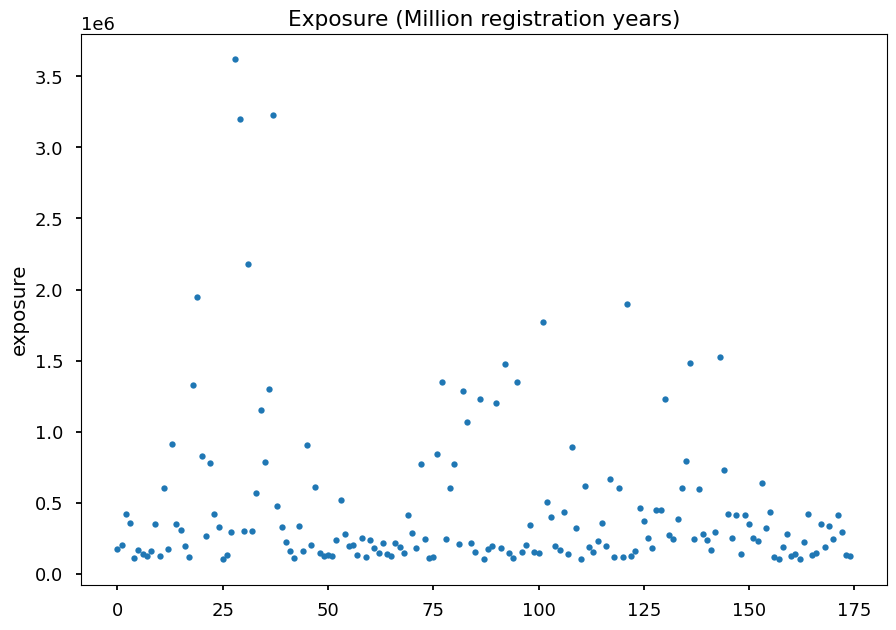

In [10]:
plt.plot(exposure, '.')
plt.title("Exposure (Million registration years)")
plt.ylabel("exposure")

Text(0, 0.5, 'fatalities')

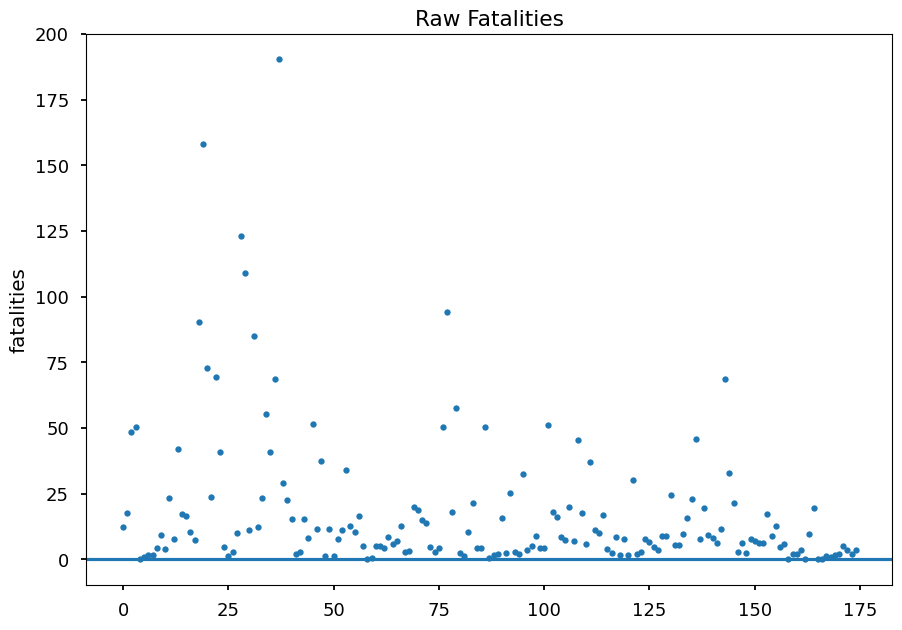

In [12]:
plt.plot(fatalities, '.')
plt.axhline()
plt.title("Raw Fatalities")
plt.ylabel("fatalities")

In [15]:
def car_model(exposure, fatalities):  
    with pm.Model() as model:
        pooled_rate = pm.Uniform('pooled_rate', lower=0.0, upper=1.0)
        κ_log = pm.Exponential('κ_log', lam=1.5)
        κ = pm.Deterministic('κ', np.exp(κ_log))

        #Note: rate is bound [0 1], so make sure 1000 fatalities / 1M is a rate of 1.
        state_rate = pm.Beta('state_rate', 
                             alpha=pooled_rate*κ, 
                             beta=(1.0-pooled_rate)*κ, 
                             shape=len(fatalities))
        observed_fatalities = pm.Poisson('y', mu=state_rate*exposure, observed=fatalities)


    return model

In [16]:
with car_model(exposure, fatalities):
    trace = pm.sample(10000)  # , njobs=4

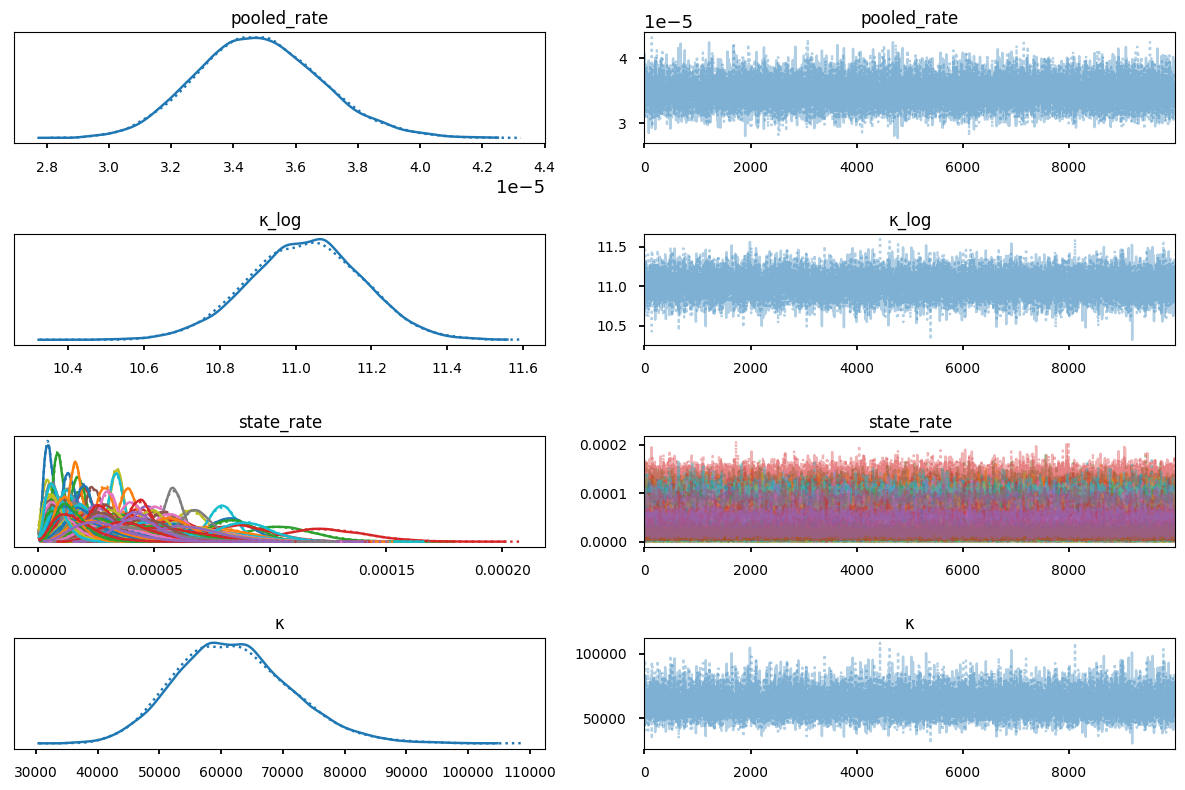

In [18]:
pm.plot_trace(trace);
plt.tight_layout()

In [21]:
trace

Inference data with groups:
	> posterior
	> sample_stats
	> observed_data

In [24]:
# trace['state_rate']
import arviz as az
az.summary(trace)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
pooled_rate,0.000,0.00,0.000,0.000,0.000,0.000,27359.0,16771.0,1.0
κ_log,11.025,0.15,10.732,11.294,0.001,0.001,12914.0,13193.0,1.0
state_rate[0],0.000,0.00,0.000,0.000,0.000,0.000,31599.0,14113.0,1.0
state_rate[1],0.000,0.00,0.000,0.000,0.000,0.000,25756.0,13339.0,1.0
state_rate[2],0.000,0.00,0.000,0.000,0.000,0.000,27859.0,13087.0,1.0
...,...,...,...,...,...,...,...,...,...
state_rate[171],0.000,0.00,0.000,0.000,0.000,0.000,24493.0,12876.0,1.0
state_rate[172],0.000,0.00,0.000,0.000,0.000,0.000,29522.0,12649.0,1.0
state_rate[173],0.000,0.00,0.000,0.000,0.000,0.000,25603.0,12296.0,1.0
state_rate[174],0.000,0.00,0.000,0.000,0.000,0.000,28941.0,12804.0,1.0


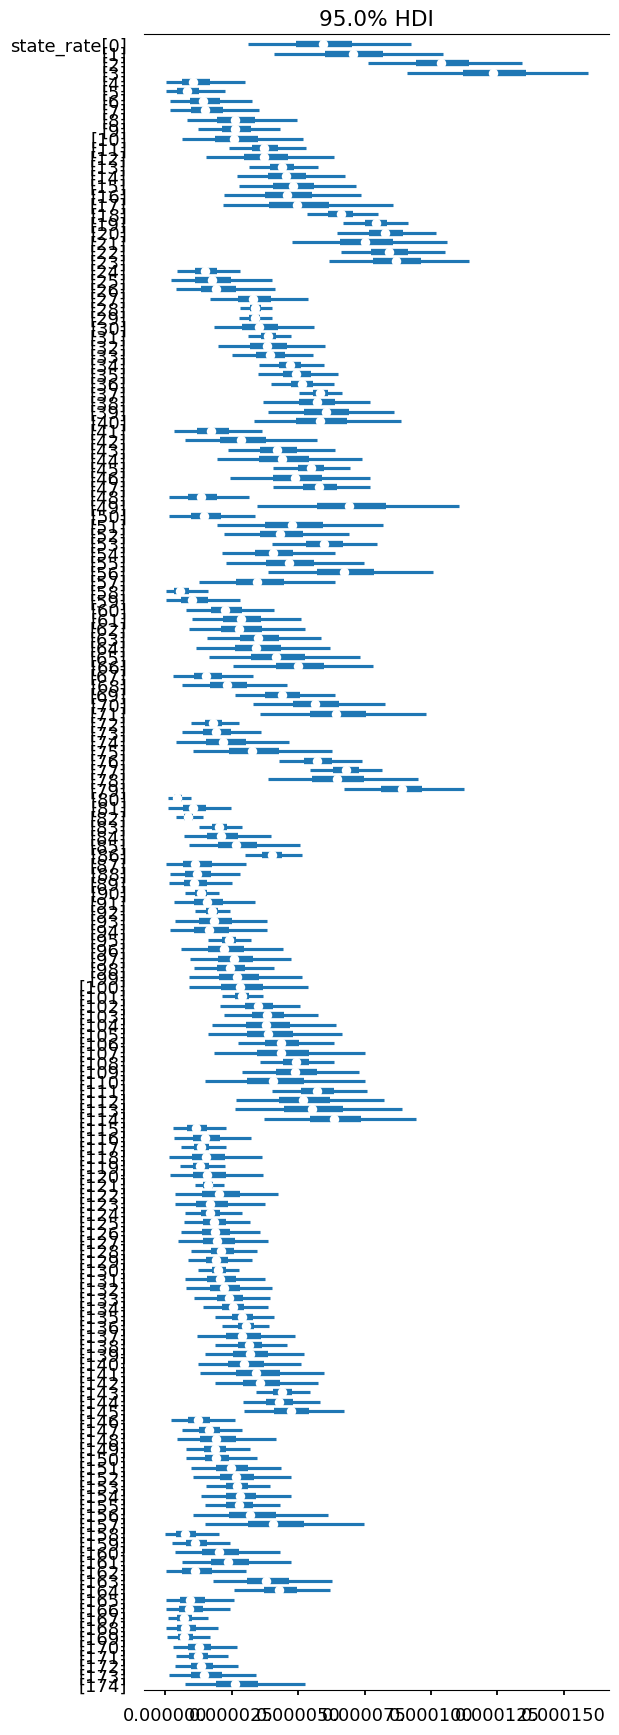

In [30]:
az.plot_forest(trace, var_names=["state_rate"], combined=True, hdi_prob=0.95);


IndexError: ignored

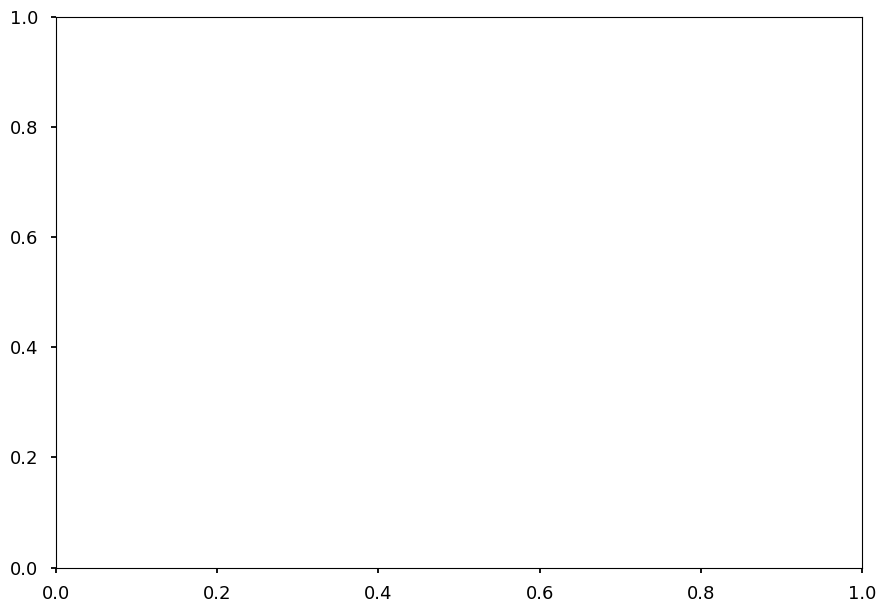

In [29]:
# trace2 = trace.posterior.stack(draws=("chain", "draw"))
# plt.vlines(trace["switchpoint"].mean(), disaster_data.min(), disaster_data.max(), color="C1")


fig, ax = plt.subplots(1, 1)
for state in ('Volkswagen Golf', 'Chevrolet Sonic', 'Lexus NX 200t 4WD', 'Volvo XC60 4WD', 'Tovota Camry'):
    sns.kdeplot(trace['state_rate'][:, df.model == state], label='{} fatality rate'.format(state))
# sns.kdeplot(trace['google_rate'], label='Google fatality rate')
# fig.set_size_inches(18.5, 10.5)
# ax.set_xlim(xmin=0)
# ax.set_ylim(ymin=-10)
ax.set_title('Estimated fatality rate of self driving cars compared to a few states')
ax.set_xlabel('Fatalities per 1 million miles')

ax.legend();